# Kaggle - Recipe Ingredients 

https://www.kaggle.com/kaggle/recipe-ingredients-dataset

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin,  TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV

%matplotlib inline

In [2]:
#Define a list of additiona stopwords.
block_words = [
    'and',
    'fresh',
    'salt',
    'unsalted',
    'chop',
    'chopped',
    'ground',
    'extra',
    'virgin',
    'clove',
    'powder', 
    'red',
    'white',
    'purple',
    'black',
    'yellow',
    'green',
    'brown',
    'bone',
    'skin',
    'skinless',
    'boneless',
    'slice',
    'fat',
    'free',
    'fine',
    'sauce',
    'seed',
    'water',
    'light',
    'heavy',
    'half',
    'less',
    'medium',
    'sea',
    'kosher',
    'bell',
    'mince'    
  ]

### Custom Transformers 

In [3]:
class PreprocString(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        def nltk2wordnet(nltk_tag):
            """Dictionary to map NLTK POS tags and word2vec tags. 
            """
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:          
                return None

        def word_splitter(ingr_list):

            #Replace non-alphabetic characters with white spaces.
            tokens = np.hstack([re.sub('[^a-zA-Z]+', ' ', s).split() for s in ingr_list])
            
            #POS tagging. Tag words as verbs, adverbs and so on.
            #tokens = [pos_tag(words) for words in tokens]
            tokens = pos_tag(tokens)

            #Convert POS tag to wordnet tag. Needed for lemmatizer.
            tokens = [(token[0],nltk2wordnet(token[1])) for token in tokens]

            #Lemmatize words. I.e., remove conjugation, etc. flowers --> flower.
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(token[0], token[1]) for token in tokens
                      if token[1] is not None]
            
            #Assemble lists back to strings to use in TFIDF.
            return ' '.join(tokens)
        
        return [word_splitter(ingredients) for ingredients in X]

### Read the Data

In [4]:
#Read and inspect input data.
train = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [5]:
print(train.shape)
print(test.shape)

(39774, 3)
(9944, 2)


### Impute cuisine as NaN in the test data
This will make concatenating the train and test data easier, which is important when cleaning the whole data to remove tokens that do not appear in many documents.

In [6]:
train['is_train'] = np.ones(train.shape[0])
test['is_train'] = np.zeros(test.shape[0])

In [7]:
nan_array = np.empty(test.shape[0])
nan_array[:] = np.nan
test['cuisine'] = nan_array

### Label Distribution

In [8]:
labels = train['cuisine'].unique()
print('There are %d unique lables' %len(labels))
labels

There are 20 unique lables


array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

Text(0, 0.5, 'Number of Recipes')

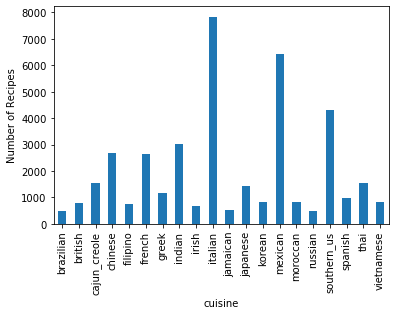

In [9]:
df_aux = train.groupby(['cuisine'])['id'].count()
ax = df_aux.plot(kind='bar')
ax.set_ylabel('Number of Recipes')

# Data Preprocessing

### Combine train and test ingredients for data investigation

In [10]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.shape

(49718, 4)

### Process the list of ingredients

See class PreprocString above.
In summary: remove non-alphabetic characters, lemmatize tokens and get concatenated strings per recipe for the application of CountVectorizer.

In [15]:
ps = PreprocString()
filtered_ingr = ps.fit_transform(all_data['ingredients'].values)
filtered_ingr[0:5]

['romaine lettuce black olives grape tomato garlic pepper purple onion season garbanzo bean feta cheese crumbles',
 'plain flour ground salt tomato grind black pepper thyme egg green tomato yellow corn meal milk vegetable oil',
 'egg pepper salt mayonaise cooking oil green chilies grill chicken breast garlic powder yellow onion soy sauce butter chicken liver',
 'water vegetable oil wheat salt',
 'black pepper shallot cornflour cayenne pepper onion garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf']

### Create a bag of words

In [16]:
cv = CountVectorizer(stop_words=block_words, min_df=10)
cv_fit = cv.fit_transform(filtered_ingr)
cv_fit

<49718x1479 sparse matrix of type '<class 'numpy.int64'>'
	with 707190 stored elements in Compressed Sparse Row format>

In [17]:
word_list = cv.get_feature_names();
count_list = cv_fit.toarray().sum(axis=0)  

In [18]:
df_counts = pd.DataFrame.from_dict({'Ingredient':word_list, 'Count':count_list})
df_counts.sort_values(by=['Count'], inplace=True, ascending=False)
df_counts.reset_index(inplace=True)
print(df_counts.shape)
df_counts.head()

(1479, 3)


,index,Ingredient,Count
0,880,oil,29102
1,886,onion,24049
2,533,garlic,23624
3,951,pepper,23214
4,1299,sugar,15650


### Distribution of post-processed tokens in the whole corpus

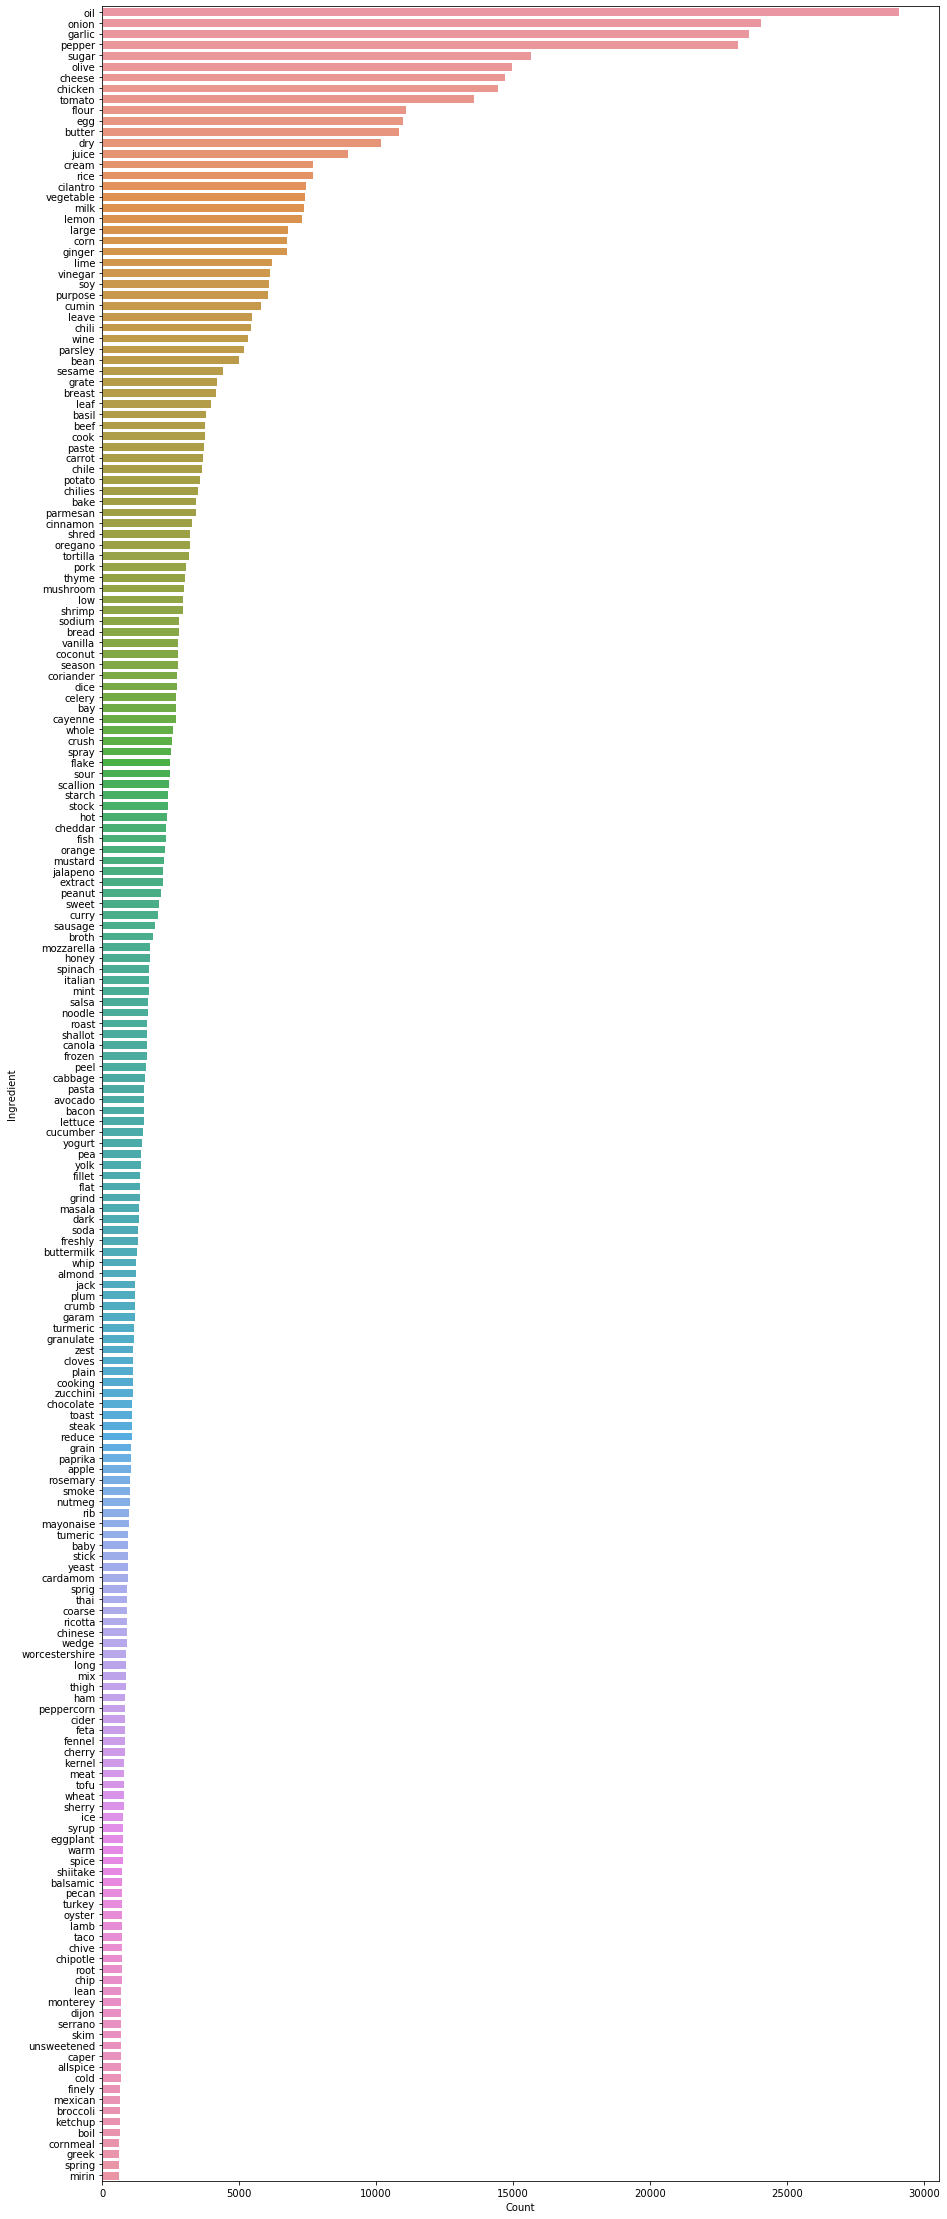

In [19]:
f, ax = plt.subplots(figsize=(15, 40))
sns.set(font_scale=0.8)
ax = sns.barplot(x='Count', y='Ingredient', data=df_counts[0:200])

### Distribution of Number of Ingredients (after text processing)

In [20]:
count_tokens_per_doc = cv_fit.toarray().sum(axis=1)  

In [21]:
print('Minimum number documents with zero tokens %d' %len(np.where(count_tokens_per_doc == 0)[0]))
print('Indexes are: ', np.argwhere(count_tokens_per_doc == 0))

Minimum number documents with zero tokens 3
Indexes are:  [[ 3670]
 [21335]
 [32105]]


In [22]:
print(all_data.iloc[3670])
print(all_data.iloc[21335])
print(all_data.iloc[32105])

id                              2444
cuisine                  southern_us
ingredients    [greens, kosher salt]
is_train                           1
Name: 3670, dtype: object
id                                 23612
cuisine                         jamaican
ingredients    [salt, water, breadfruit]
is_train                               1
Name: 21335, dtype: object
id                12805
cuisine        japanese
ingredients     [water]
is_train              1
Name: 32105, dtype: object


All the documents with 0 tokens are in the **train** sample and can be removed

In [23]:
drop_idx = np.hstack(np.argwhere(count_tokens_per_doc == 0))
print(all_data.shape)
print('The following indexes can be dropped: ', drop_idx)
all_data.drop(drop_idx, inplace=True)
print(all_data.shape)

(49718, 4)
The following indexes can be dropped:  [ 3670 21335 32105]
(49715, 4)


In [24]:
print('Largest number of tokens in a doc is: ', max(count_tokens_per_doc))

Largest number of tokens in a doc is:  104


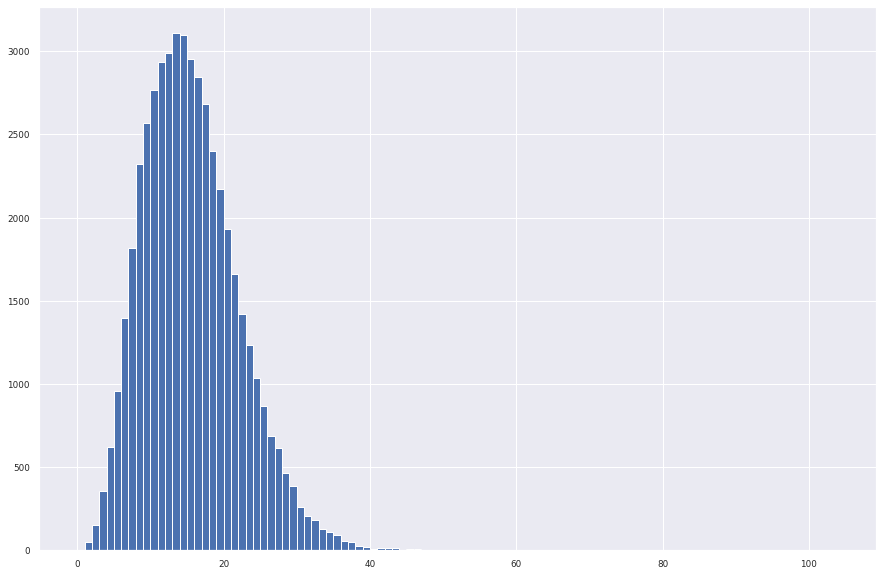

In [25]:
f, ax = plt.subplots(figsize=(15, 10))
ax.hist(count_tokens_per_doc, bins=np.arange(0,max(count_tokens_per_doc) + 1))
plt.show()

# Model training

### Prepare the data

In [27]:
#We will have to vectorize the data again since rows have been dropped.

#Create a pipeline.
preproc = PreprocString()
tfidf = TfidfVectorizer(stop_words=block_words, min_df=10)

pipe = Pipeline([
    ('preproc', preproc),
    ('tfidf', tfidf),
])

In [28]:
vec_all_data = pipe.fit_transform(all_data['ingredients'].values)

In [34]:
#Recover the train and test portions after using the whole text for vectorization.
train_updated = all_data[all_data['is_train']==1]
n_train = train_updated.shape[0]

X_train = vec_all_data[:n_train]
y_train_raw = train_updated['cuisine'].values
X_test = vec_all_data[n_train:]

### Encode the labels

In [36]:
le = OneHotEncoder()
y_train = le.fit_transform(y_train_raw.reshape(-1, 1)).toarray()
y_train.shape

(39771, 20)

### Grid Search for best linear SVM C
The linear SVM algorithm is a good method to classify text data. This is because it fares well in high dimensional spaces where the data tend to cluster.

In [43]:
%%time
model_to_set = OneVsRestClassifier(svm.SVC(kernel='linear', gamma='scale', random_state=42))

parameters = {"estimator__C": np.arange(3.81,4.41,.1)}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters,
                             n_jobs=6, cv=3, scoring='accuracy', verbose=2)

model_tunning.fit(X_train, y_train)

print(model_tunning.best_score_)
print(model_tunning.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/home/heringer/anaconda2/envs/py37/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed: 10.0min remaining:  2.5min
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed: 14.1min finished


0.6602801035930703
{'estimator__C': 4.109999999999999}
CPU times: user 6min 58s, sys: 595 ms, total: 6min 59s
Wall time: 21min 5s


In [46]:
best_C = model_tunning.best_params_['estimator__C']

4.109999999999999

### Train best SVM model with whole train data

In [53]:
%%time
model = OneVsRestClassifier(svm.SVC(kernel='linear', gamma='scale', C=best_C, random_state=42))
model.fit(X_train, y_train)

CPU times: user 7min 10s, sys: 59.7 ms, total: 7min 10s
Wall time: 7min 10s


OneVsRestClassifier(estimator=SVC(C=4.109999999999999, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=False, random_state=42,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [54]:
#Performance on the train data
y_train_pred = model.predict(X_train)
y_train_pred = le.inverse_transform(y_train_pred).flatten()
print('Accuracy on train data: %.3f' %accuracy_score(y_train_pred, y_train_raw))

Accuracy on train data: 0.733


### Produce submission file

In [55]:
#Performance on the test data
y_pred = model.predict(X_test)
y_pred = le.inverse_transform(y_pred).flatten()

In [63]:
ids = all_data[n_train:]['id'].values

fpath = './../submission.csv'
df_out = pd.DataFrame.from_dict({'id': ids, 'cuisine': y_pred})
df_out.to_csv(fpath, index=False)